SVM Model Accuracy: 100.00%
Naive Bayes Model Accuracy: 100.00%
Random Forest Model Accuracy: 97.62%


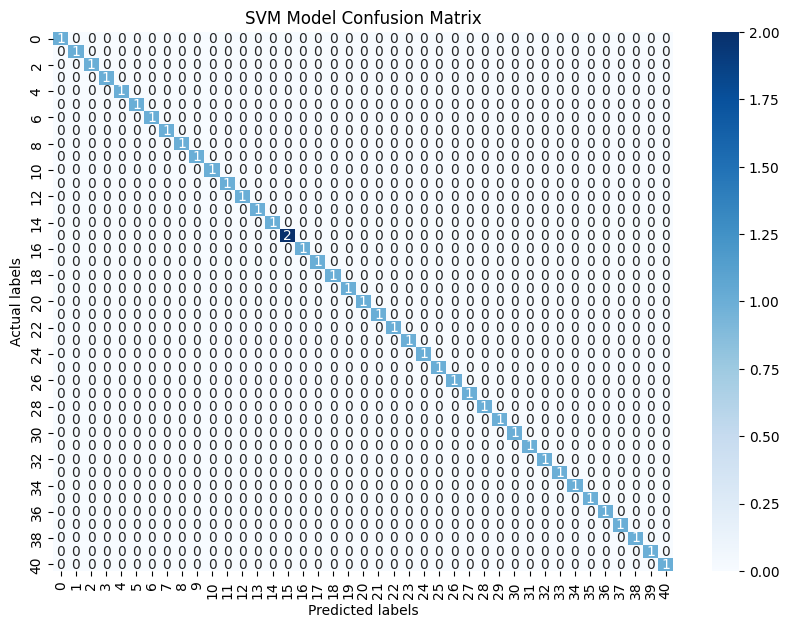

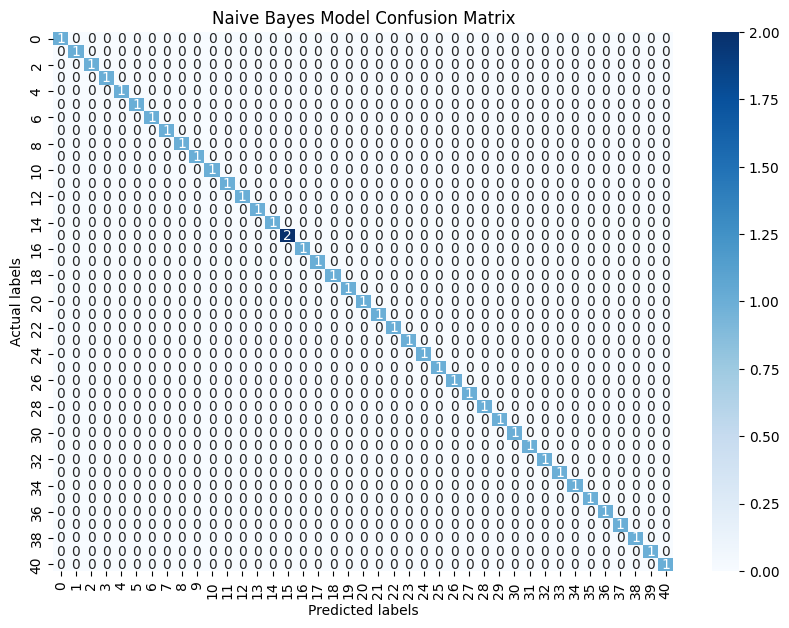

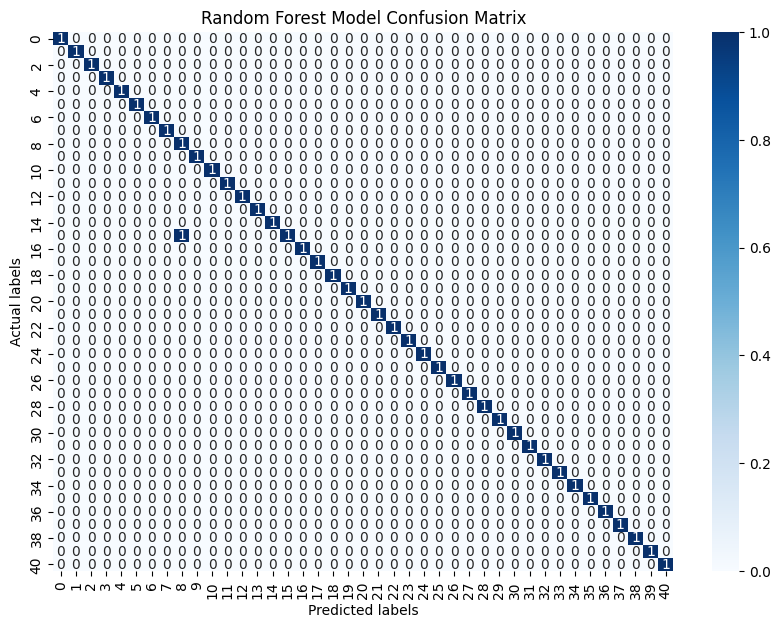

/var/folders/1x/y786hcj51zz6j2jzjsth_kqh0000gn/T/ipykernel_20505/519883921.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  symptoms = [symptom for symptom in symptom_index.keys() if row[symptom_index[symptom]] == 1]


Final Combined Model Accuracy: 100.00%
['Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis', 'Arthritis'

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix    
import pickle
from collections import Counter

# Load and preprocess the training data
DATA_PATH = "Training.csv"
data = pd.read_csv(DATA_PATH).dropna(axis=1)

encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Initialize models
svm_model = SVC()
nb_model = GaussianNB()
rf_model = RandomForestClassifier(random_state=18)

# Train models
svm_model.fit(X, y)
nb_model.fit(X, y)
rf_model.fit(X, y)

# Load and preprocess the test data
test_data = pd.read_csv("Testing.csv").dropna(axis=1)

test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])

# Make predictions
svm_preds = svm_model.predict(test_X)
nb_preds = nb_model.predict(test_X)
rf_preds = rf_model.predict(test_X)

# Save the models
pickle.dump(svm_model, open('svm_model.pkl', 'wb'))
pickle.dump(nb_model, open('nb_model.pkl', 'wb'))
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))

# Calculate and print accuracy for each model
svm_accuracy = accuracy_score(test_Y, svm_preds)
print(f"SVM Model Accuracy: {svm_accuracy * 100:.2f}%")

nb_accuracy = accuracy_score(test_Y, nb_preds)
print(f"Naive Bayes Model Accuracy: {nb_accuracy * 100:.2f}%")

rf_accuracy = accuracy_score(test_Y, rf_preds)
print(f"Random Forest Model Accuracy: {rf_accuracy * 100:.2f}%")

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(test_Y, svm_preds, "SVM Model Confusion Matrix")
plot_confusion_matrix(test_Y, nb_preds, "Naive Bayes Model Confusion Matrix")
plot_confusion_matrix(test_Y, rf_preds, "Random Forest Model Confusion Matrix")

# Create a dictionary for symptom indexing
symptoms = X.columns.values
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index

# Data dictionary for the prediction function
data_dict = {
    "symptom_index": symptom_index,
    "predictions_classes": encoder.classes_
}

def predictDisease(symptoms_list):
    final_predictions = []
    for symptoms in symptoms_list:
        input_vector = [0] * len(X.columns)
        for symptom in symptoms:
            if symptom in symptom_index:  # Check if the symptom is in our index
                index = symptom_index[symptom]
                input_vector[index] = 1

        # Convert the input vector to a DataFrame with matching column names
        input_df = pd.DataFrame([input_vector], columns=X.columns)

        # Make predictions with all models
        rf_prediction = encoder.classes_[rf_model.predict(input_df)[0]]
        nb_prediction = encoder.classes_[nb_model.predict(input_df)[0]]
        svm_prediction = encoder.classes_[svm_model.predict(input_df)[0]]

        # Find the most common prediction among the three models
        predictions = [rf_prediction, nb_prediction, svm_prediction]
        final_prediction = Counter(predictions).most_common(1)[0][0]
        final_predictions.append(final_prediction)

    return final_predictions

def calculate_final_accuracy(test_data, test_labels):
    # Convert test data symptoms to the required input format
    symptoms_list = []
    for _, row in test_data.iterrows():
        symptoms = [symptom for symptom in symptom_index.keys() if row[symptom_index[symptom]] == 1]
        symptoms_list.append(symptoms)

    # Get final combined predictions for the test dataset
    final_predictions = predictDisease(symptoms_list)

    # Convert predictions to numeric labels to compare with test_labels
    final_predictions_labels = [list(encoder.classes_).index(pred) for pred in final_predictions]

    # Calculate accuracy
    final_accuracy = accuracy_score(test_labels, final_predictions_labels)
    print(f"Final Combined Model Accuracy: {final_accuracy * 100:.2f}%")

# Call the function with your test data
calculate_final_accuracy(test_X, test_Y)


# Testing the prediction function
print(predictDisease(test_data))
